# Create geojson file from list of PUDO coords
Loops through all days of the week and all time windows to create geojson files for a given ward. 

**NB**: ward must be entered manually as a variable (i.e. script does not also loop through all wards).   

**Resources**  
See /home/test/Documents/PROJECTS/VFH/iPython_Notebooks/dv_pudo_profiles.ipynb for more info.  
ref: https://geoffboeing.com/2015/10/exporting-python-data-geojson/  
Huom: `with open(output_filename, 'wb') as output_file:` should be `'w'` not `'wb'` 

### Trip data obtained from this query:

```
CREATE TABLE cnangini.trip_data_092018_timewin AS
SELECT 
	pickup_datetime, 
	TO_CHAR(pickup_datetime, 'FMDay') dow,
	TO_CHAR(pickup_datetime, 'HH24') HH,
	dropoff_datetime, pickup_ward2018, dropoff_ward2018, 
	pickup_gc_intersection_id, dropoff_gc_intersection_id,
	pickup_neighbourhood, dropoff_neighbourhood,
   case 
   		when (DATE_PART('isodow',a.pickup_datetime) < 6) --WEEKDAY
			AND (DATE_PART('hour',a.pickup_datetime) in (7,8,9)) 
		then 'amPeak'
		when (DATE_PART('isodow',a.pickup_datetime) >= 6) --WEEKEND	
			AND (DATE_PART('hour',a.pickup_datetime) in (7,8,9,10,11)) 
		then 'amPeak'
		
		when (DATE_PART('isodow',a.pickup_datetime) < 6) --WEEKDAY
			AND (DATE_PART('hour',a.pickup_datetime) in (10,11,12,13,14,15)) 
		then 'midday'
		when (DATE_PART('isodow',a.pickup_datetime) >= 6) --WEEKEND	
			AND (DATE_PART('hour',a.pickup_datetime) in (12,13,14,15,16,17,18)) 
		then 'midday'
		
    	when (DATE_PART('isodow',a.pickup_datetime) < 6) --WEEKDAY
 			AND (DATE_PART('hour',a.pickup_datetime) in (16,17,18)) 
 		then 'pmPeak'
    
        when DATE_PART('hour',a.pickup_datetime) in (19,20,21,22,23,0,1,2) then 'nightI'
        when DATE_PART('hour',a.pickup_datetime) in (3,4,5,6) then 'nightII'
        else 'outside_windows'
        end as timewindow,

pickup.geom as pickup_geom, dropoff.geom as dropoff_geom,
ST_Y(pickup.geom) as lat_pickup,
ST_X(pickup.geom) as lon_pickup,
ST_Y(dropoff.geom) as lat_dropoff,
ST_X(dropoff.geom) as lon_dropoff
FROM ptc.trip_data_new_geom a
inner join gis.centreline_intersection pickup on pickup.int_id = pickup_gc_intersection_id 
inner join gis.centreline_intersection dropoff on dropoff.int_id = dropoff_gc_intersection_id
WHERE pickup_mun_id = 69 AND dropoff_mun_id = 69
AND pickup_datetime > '20180901' AND pickup_datetime < '20181001'

```

### And then each day extracted with this query:

```
CREATE TABLE cnangini.trip_data_092018_timewin_monday AS
SELECT 
	dow, HH, timewindow, pickup_datetime, dropoff_datetime, 
	pickup_ward2018, dropoff_ward2018, 
	pickup_gc_intersection_id, dropoff_gc_intersection_id,
	pickup_neighbourhood, dropoff_neighbourhood,
	pickup_geom, dropoff_geom, lat_pickup, lon_pickup,
	lat_dropoff, lon_dropoff
FROM cnangini.trip_data_092018_timewin
WHERE dow='Monday'
```

In [1]:
import sys
sys.executable

'/home/test/anaconda3/envs/vfh/bin/python'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

from IPython.display import HTML, display
import datetime
import matplotlib.dates as mdates
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

from datetime import datetime

import json

# Functions

In [3]:
def round_coord(df, cols):
    n=4    
    for this_col in cols:
        df[this_col] = df[this_col].round(decimals=n)
    return df

In [4]:
def agg_counts(df, this_type):
    
    df_agg=pd.DataFrame()
    
    this_ward = this_type + '_ward2018'
    cols = ['dow','timewindow','lat_'+ this_type,'lon_'+ this_type,
            this_type+'_gc_intersection_id', this_type +'_neighbourhood']
    if this_type == 'pickup':
        idx_name = 'pcounts'
    else:
        idx_name = 'dcounts'

    df_agg=df.loc[(df[this_ward]==ward) & 
                  (df['timewindow']==this_tod)].groupby(cols).size().reset_index(name=idx_name)

    df_agg = df_agg.rename(columns={'lat_'+this_type: 'latitude'})
    df_agg = df_agg.rename(columns={'lon_'+this_type: 'longitude'})
    df_agg = df_agg.rename(columns={this_type+'_gc_intersection_id': 'intersection_id'})
    df_agg = df_agg.rename(columns={this_type+'_neighbourhood': 'nn'})
    
    # Add extra column to allow for stacking later on
    if this_type == 'pickup':
        df_agg = df_agg.assign(dcounts=0)
    else:
        idx_name = 'dcounts'
        df_agg = df_agg.assign(pcounts=0)
    
    return df_agg

In [5]:
# https://geoffboeing.com/2015/10/exporting-python-data-geojson/
def df_to_geojson(df, properties, lat="latitude", lon="longitude"):
    geojson = {"type":"FeatureCollection", "features":[]}
    for _, row in df.iterrows():
        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"Point",
                               "coordinates":[]}}
        feature["geometry"]["coordinates"] = [row[lon],row[lat]]
        for prop in properties:
            if prop=="story":
                this_prop = row[prop]
            else:
                this_prop = int(row[prop])
            feature["properties"][prop] = this_prop
        geojson["features"].append(feature)
    return geojson

# Variables

In [6]:
# Stores final geojson file with all days of week, times of day, pu, do and pudo
o = {}

## geoJSON format for this_day, this_tod
Format:  
```
{
    this_day: {
		this_tod: {
			'pu': geojson_pu_layer,
			'pudo':geojson_pudo_layer,
			'do':geojson_do_layer
		}
 ``` 
 
 e.g.
 
 ```
 {
    'Monday': {
		'amPeak': {
			'pu':geojson_pu_layer,
			'pudo':geojson_pudo_layer,
			'do':geojson_do_layer
		}
 ```

In [7]:
ward=1

dd=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
tt=['amPeak','midday','pmPeak','nightI','nightII']
# NB!!!! Weekends (Saturday, Sunday) do NOT have a pmPeak

c=0   #15 #cut-off filter. Only counts >= c will be saved

# Humber Story
humber_id = 20232410

# Loop

In [8]:
for this_day in dd:
    o[this_day] = {}

    fname = '../../../Documents/PROJECTS/VFH/COT_PAGE/INTERIM_DATA/FROM_PGADMIN/tripdata_092018_' + this_day + '.csv'
    df = pd.read_csv(fname)
    
    round_coord(df, ['lat_pickup', 'lon_pickup', 'lat_dropoff', 'lon_dropoff'])
    
    # 2. Filter out rows where neither pickup or dropoff wards are the ward of interest
    df['keep'] = np.nan
    df['latitude'] = np.nan
    df['longitude'] = np.nan

    df.loc[(df['pickup_ward2018']==ward) | (df['dropoff_ward2018']==ward), 'keep'] = 1    
    df = df[df['keep'].notnull()] # Keep only rows where `keep` is not null
    
    # 3. Mark if row is a pickup or a dropoff
    df['pu'] = np.nan
    df['do'] = np.nan
    df.loc[df['pickup_ward2018']==ward, 'pu'] = 1
    df.loc[df['dropoff_ward2018']==ward, 'do'] = 1
    
    for this_tod in tt:
        if this_tod == 'pmPeak' and (this_day == 'Saturday' or this_day == 'Sunday'):
            print("Weekends have no pmPeak period")
        else:
            o[this_day][this_tod] = {}

            # 4. Aggregate pickups and dropoffs for this_tod
            df_agg_pu = pd.DataFrame()
            df_agg_do = pd.DataFrame()
            df_agg_pu = agg_counts(df, 'pickup')
            df_agg_do = agg_counts(df, 'dropoff')

            # 5. Stack pickups on top of dropoffs
            df_merge=pd.DataFrame()
            df_merge=pd.concat([df_agg_pu, df_agg_do],sort=False)

            # 6. Group on common intersection_id
            # For each same intersection, collapse row for pickups and row for dropoffs into one single row 
            # with pcounts and dcounts representing the total counts for each.
            df_merge_gr=pd.DataFrame()
            df_merge_gr=df_merge.groupby(['intersection_id','latitude','longitude','nn'],as_index=False).sum()
            
            # Placeholder for story
            if ward==1:
#                 df_merge_gr['story']='0'   
                if this_day=='Monday' and this_tod=='amPeak':
                    df_merge_gr['story']='0'   
                    df_merge_gr.loc[df_merge_gr['intersection_id']==humber_id, 'story']='humber'

            # 7. Make the dataframes for each layer
            # Need 3 separate dataframes for PUDOS, PU only, DO only.
            df_pudo_layer = pd.DataFrame()
            df_pu_layer = pd.DataFrame()
            df_do_layer = pd.DataFrame()

            df_pudo_layer = df_merge_gr.loc[(df_merge_gr['pcounts']>0) & (df_merge_gr['dcounts']>0)]
            df_pu_layer = df_merge_gr.loc[(df_merge_gr['pcounts']>0) & (df_merge_gr['dcounts']==0)]
            df_do_layer = df_merge_gr.loc[(df_merge_gr['pcounts']==0) & (df_merge_gr['dcounts']>0)]

            # 8. Create the geojsons for all counts >= c
            geojson_pu_layer = df_to_geojson(df_pu_layer.loc[(df_pu_layer["pcounts"]>=c)], ["pcounts","nn"])
            geojson_do_layer = df_to_geojson(df_do_layer.loc[(df_do_layer["dcounts"]>=c)], ["dcounts","nn"])
            if ward==1 and this_day=='Monday' and this_tod=='amPeak':
                geojson_pudo_layer = df_to_geojson(df_pudo_layer.loc[
                                                ((df_pudo_layer["pcounts"]+df_pudo_layer["dcounts"]) >= c)
                                                ], ["pcounts","dcounts","nn","story"])
            else:
                geojson_pudo_layer = df_to_geojson(df_pudo_layer.loc[
                                ((df_pudo_layer["pcounts"]+df_pudo_layer["dcounts"]) >= c)
                                ], ["pcounts","dcounts","nn"])

            o[this_day][this_tod]['pu'] = geojson_pu_layer
            o[this_day][this_tod]['pudo'] = geojson_pudo_layer
            o[this_day][this_tod]['do'] = geojson_do_layer

Weekends have no pmPeak period
Weekends have no pmPeak period


# Write geojson to file
Use `separators=(',', ':')` with `json.dump` for a minified file.  

ref: https://stackoverflow.com/questions/33233313/python-json-dumpsval-to-output-minified-json

In [9]:
print('ward ' + repr(ward) + ', cutoff ' + repr(c))

ward 1, cutoff 0


In [10]:
mydir = '../src/geojson/'
# mydir = '/home/nangini/Documents/PROJECTS/BDITTO/VFH/DATA_STORY/DATA/INDIVIDUAL_GEOJSONS/'

output_filename = mydir + 'w' + repr(ward) + '_agg_cutoff_' + repr(c) + '.geojson'

with open(output_filename, 'w') as output_file:
    output_file.write('')
    json.dump(o, output_file, separators=(',', ':')) 

In [11]:
print("200 OK")

200 OK


cutoff=15  
`
$ ls -lh src/geojson/
-rw-r--r-- 1 test test 1.8M Feb 12 13:34 w10_agg_cutoff.geojson
-rw-r--r-- 1 test test 366K Feb 12 13:37 w1_agg_cutoff.geojson
`

cutoff=0  
`
-rw-r--r-- 1 test test 2.8M Feb 12 13:58 w10_agg_cutoff_0.geojson
-rw-r--r-- 1 test test 3.2M Feb 12 13:59 w1_agg_cutoff_0.geojson
`

# Histograms of counts
https://mode.com/example-gallery/python_histogram/

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def counts_hist(df, col, nbins):
    ax = df.hist(column=col, bins=nbins, grid=True, color='#86bf91', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", 
                      labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("")

        # Set x-axis label
        x.set_xlabel(col, labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Bin counts", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [13]:
df_pudo_layer['sum'] = np.nan

df_pudo_layer['sum'] = df_pudo_layer['dcounts'] + df_pudo_layer['pcounts']
df_pudo_layer.head(10)

/home/test/anaconda3/envs/vfh/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/test/anaconda3/envs/vfh/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,intersection_id,latitude,longitude,nn,pcounts,dcounts,sum
0,13449225,43.7601,-79.5861,2.0,3,4,7
1,13449294,43.7596,-79.5899,2.0,4,1,5
5,13449457,43.7585,-79.5894,2.0,3,13,16
9,13449560,43.7578,-79.5909,2.0,1,1,2
14,13449681,43.7571,-79.6001,2.0,3,3,6
16,13449769,43.7566,-79.6048,1.0,2,2,4
17,13449783,43.7562,-79.5883,2.0,9,16,25
20,13449815,43.7561,-79.5910,2.0,1,1,2
23,13449871,43.7559,-79.6044,1.0,2,1,3
29,13449992,43.7550,-79.5884,2.0,9,6,15


10
pickups bin width: 1.0
15
dropoffs bin width: 1.5
118
pudos bin width: 4.214285714285714


/home/test/anaconda3/envs/vfh/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


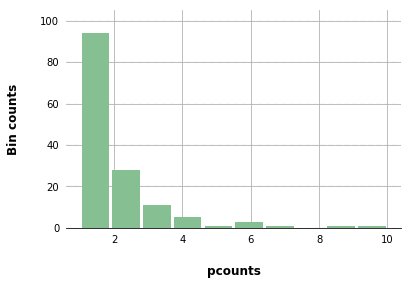

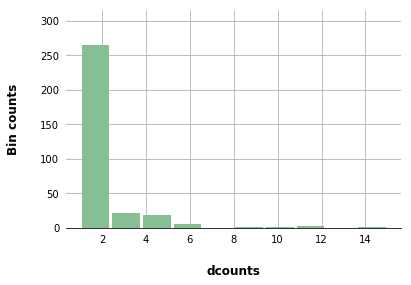

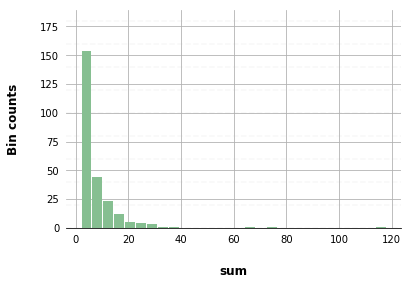

In [14]:
nbins = 10
print(df_pu_layer['pcounts'].max())
print('pickups bin width: ' + repr(df_pu_layer['pcounts'].max()/nbins))

counts_hist(df_pu_layer, 'pcounts', nbins)

print(df_do_layer['dcounts'].max())
print('dropoffs bin width: ' + repr(df_do_layer['dcounts'].max()/nbins))
counts_hist(df_do_layer, 'dcounts', nbins)

nbins = 28
print(df_pudo_layer['sum'].max())
print('pudos bin width: ' + repr(df_pudo_layer['sum'].max()/nbins))
counts_hist(df_pudo_layer, 'sum', nbins)